## Регуляризация
#### Применить методы линейной регресии, lasso, lasso cv, ridge и ridge cv к данным и вывести MSE и коэффициенты

In [103]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [104]:
#Загрузка файла
#Данные представляют собой информацио о прокате велисипедов. Учитываются факторы:
#Даты, сезона, года, месяца, праздника, дня недели, рабочего/выходного, погоды, температуры, влажности, скорости ветра, 
#количество зарегистрированных и случайных (не зарегистрирванных) пользователей
#cnt - количество арендованных велосипедов
#исследуется зависимость cnt от вышезаданных факторов


In [105]:
df = pd.read_csv('day.csv', sep=',')#, parse_dates=['dteday'])
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [106]:
df.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
730,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


In [107]:
#размер таблицы
df.shape

(731, 16)

In [108]:
#Визуализация данных
plt.rcParams['figure.figsize'] = (12,8)

<AxesSubplot:xlabel='season', ylabel='cnt'>

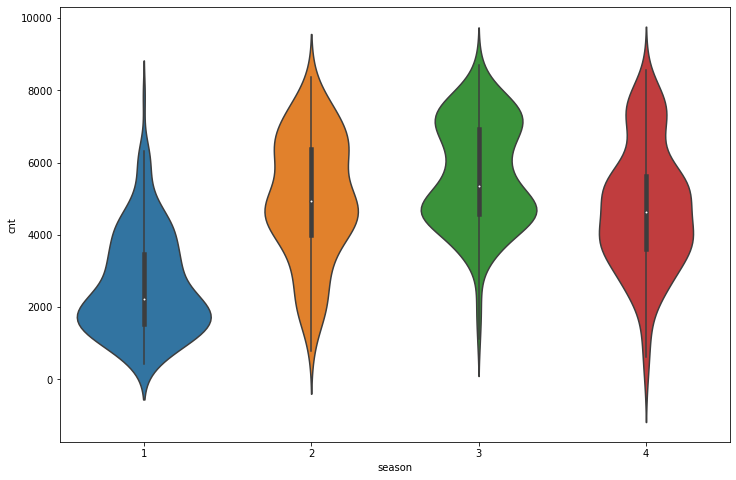

In [109]:
#зависимость количества арендованных велосипедов от сезона
#1 сезон - весна, 2 - лето, 3 - осень, 4 - зима
#весной в среднем арендовали 2000 велосипедов в день, летом - от 4000 до 8000, осенью примерно столько же, но чуть меньше, зимой -
#в среднем 4000
sns.violinplot(x=df['season'], y=df['cnt'])

<AxesSubplot:xlabel='season', ylabel='cnt'>

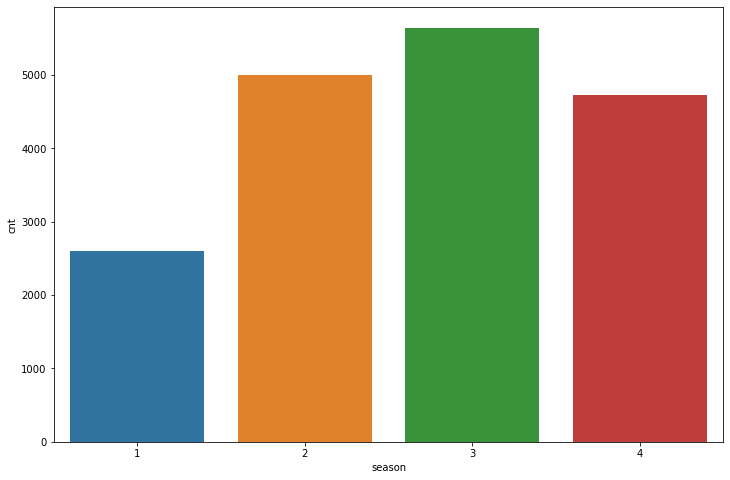

In [110]:
sns.barplot(x=df.groupby('season').mean().index, y=df.groupby('season').mean()['cnt'])

<AxesSubplot:>

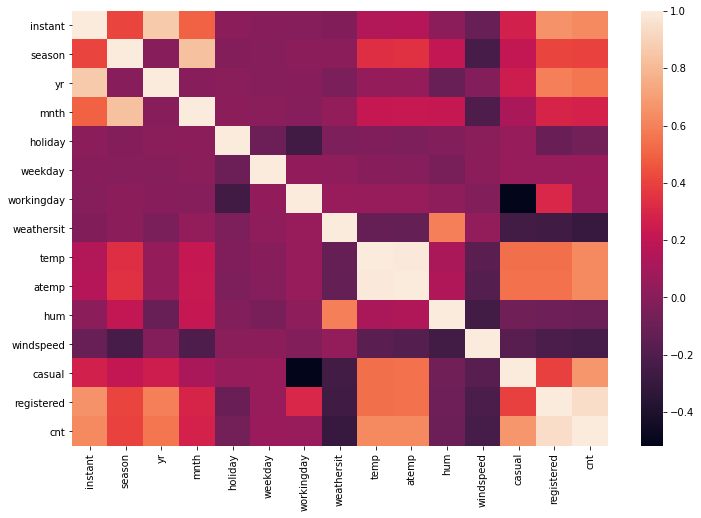

In [112]:
sns.heatmap(df.corr())

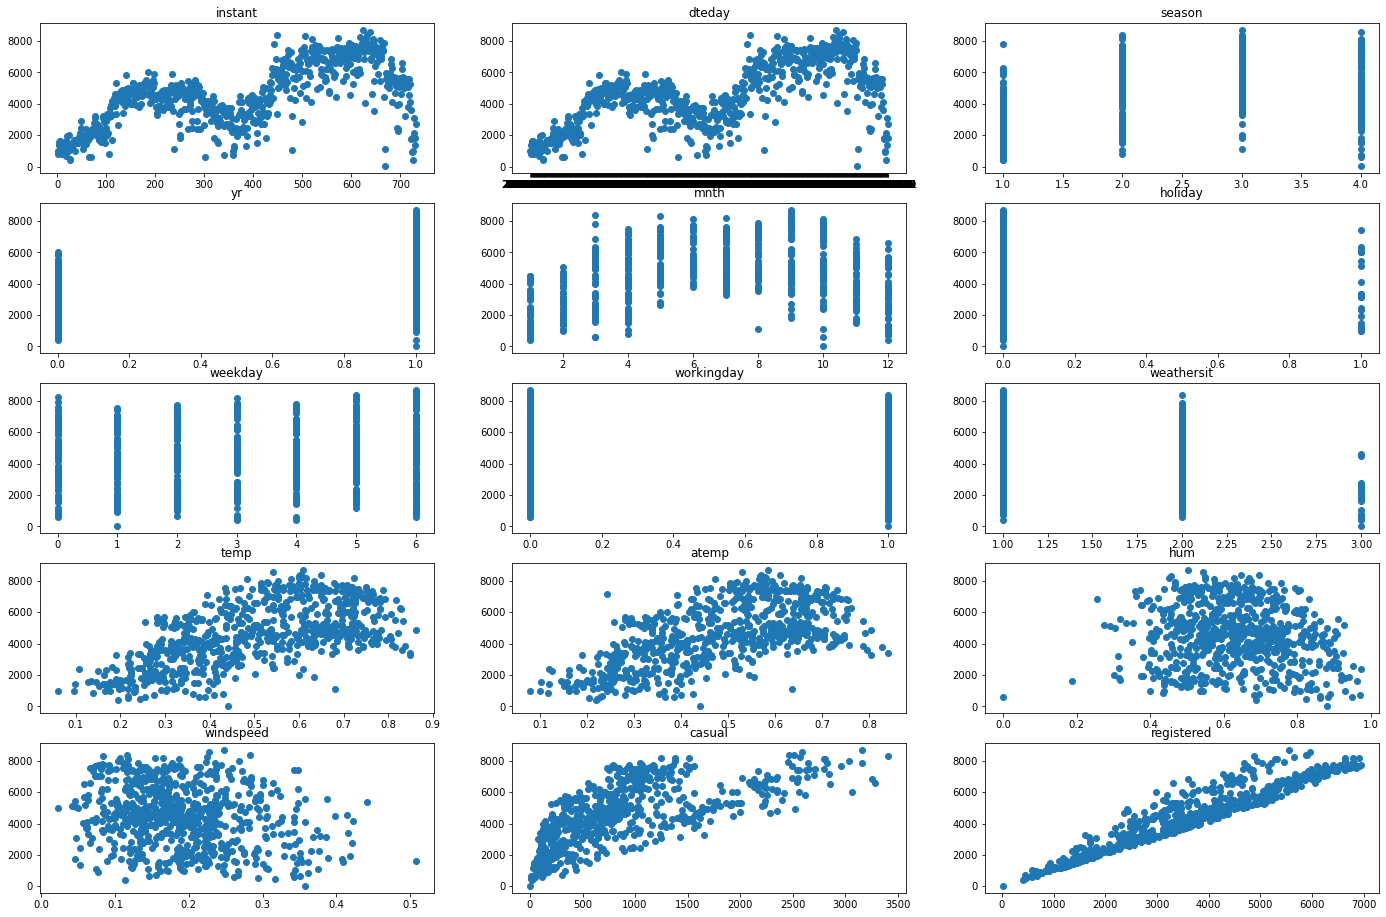

In [113]:
plt.rcParams['figure.figsize'] = (24,16)
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(5, 3, i+1)
    plt.scatter(df[col], df['cnt'])
    plt.title(col)

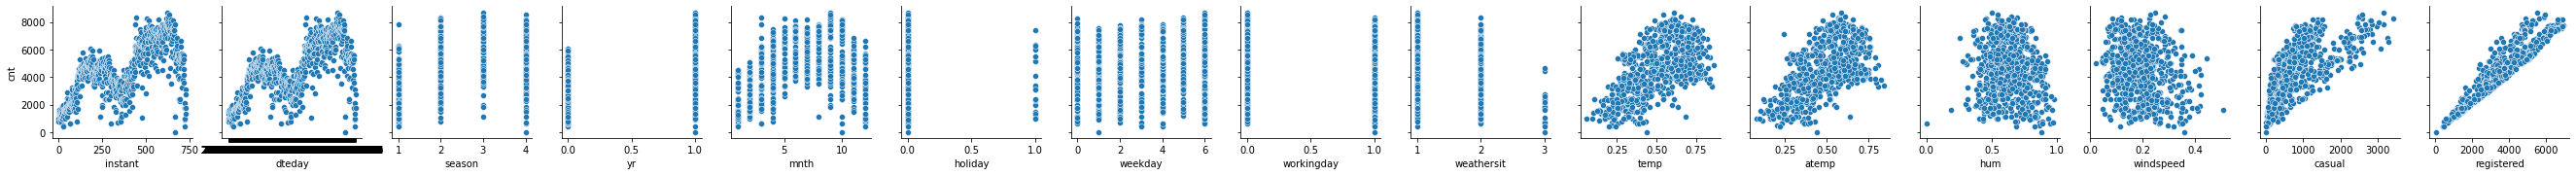

In [119]:
#Таблица рассеивания количества арендованных велосипедов от всех факторов
sns.pairplot(df, x_vars=df.columns.drop("cnt"), y_vars=["cnt"])

In [120]:
plt.rcParams['figure.figsize'] = (12,8)

<AxesSubplot:xlabel='mnth', ylabel='cnt'>

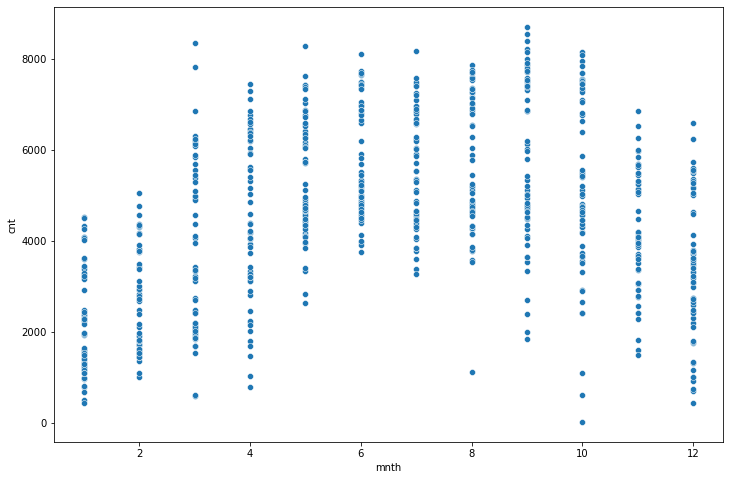

In [121]:
#отдельно рассмотрим таблицу рассеяния количества велосипедов от месяца. В среднем летом-осенью их больше всего арендуют
sns.scatterplot(x=df['mnth'],y=df['cnt'])

<AxesSubplot:xlabel='temp', ylabel='cnt'>

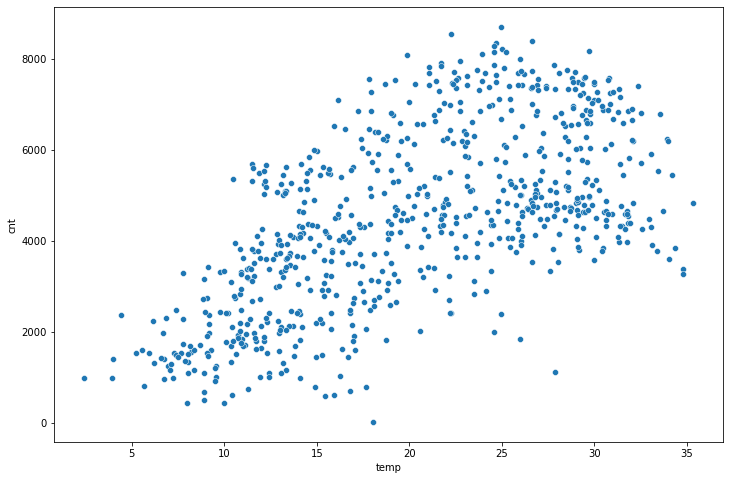

In [122]:
#Зависимость cnt от температуры воздуха (значения делятся на 41)
#вполне очевидно, что когда температура примерно 20-30 градусов (0.5-0.6), велосипеды арендуют более активнее
sns.scatterplot(x=df['temp']*41,y=df['cnt'])

<AxesSubplot:xlabel='weathersit', ylabel='cnt'>

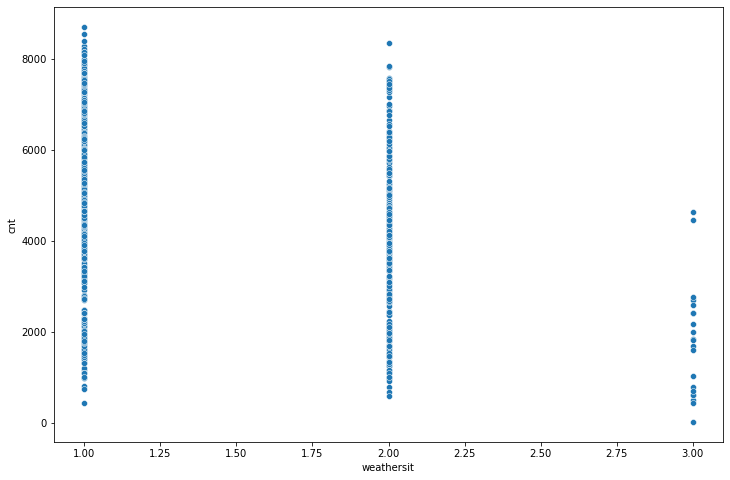

In [123]:
#Зависимость cnt от погоды
#1 - небольшая облачность
#2 - туман
#3 - легкий снег
#так же видна зависисмость что больше велосипедов арендуют в хорошую погоду. Когда идет снег, велосипеды арендуют достаточно редко
sns.scatterplot(x=df['weathersit'],y=df['cnt'])

In [124]:
#Замечание
#Визуалзация данных показывает, что некоторые столбцы в таблице не нужны. Однозначно можно убрать номер наблюдения,
#от него ничего не зависит. Дата наблюдения так же не нужна. В таблице уже есть столбцы и с днями недели и с месяцами и с годами
#Сначала исследуем зависимость cnt от всех факторов кроме этих двух, далее посмотрим, что ещё можно сделать для улучшения модели

In [125]:
df = df.drop(['instant', 'dteday'], axis=1)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [128]:
#Применить методы линейной регресии, lasso, lasso cv, ridge и ridge cv к данным и вывести MSE и коэффициенты
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [129]:
linreg = LinearRegression()
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
lasso_cv = LassoCV(random_state=42)
ridge_cv=RidgeCV()

In [131]:
#Объясняемая переменная - количество арендованных велосипедов
#Факторы - все параметры в таблице, исключая порядковый номер наблюдения и дату (у нас итак есть день, месяц, год)
y = df['cnt'].values
x = df.drop(['cnt'], axis=1).values

In [132]:
#Делим выборку на обучающую (70%) и контрольную (30%)
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.7)

In [133]:
#Стандартизация данных необходима, так как данные находятся в разных единицах измерения
#Лучше подходит стандартизация minmax, так как у нас много рваных данных, принимающих значения 0-1
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_valid)

In [135]:
#функция, которая применяет выбранный метод к данным и выводит корень MSE, коэффициенты для полученной модели и график,
#показывающий отклонения реальных значений от предсказанных по обущающей выборке
def train_validate_report(model, x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names):
    model.fit(x_train_scaled, y_train)
    R = model.score(x_train_scaled, y_train)
    print(f'Ошибка: {np.sqrt(mean_squared_error(y_valid, model.predict(x_valid_scaled)))}')
    print(f'Коэффициент детерминации: {R}')
    print(pd.DataFrame(model.coef_, feature_names, columns=['coef']).sort_values(by='coef', ascending=False))
    pred = pd.DataFrame({
        'pred':model.predict(x_valid_scaled),
        'real':y_valid})
    pred.plot()


Ошибка: 193.88688004599032
Коэффициент детерминации: 1.0
                    coef
registered  6.891000e+03
casual      3.408000e+03
temp        6.117049e-12
hum         1.464813e-12
holiday     8.941996e-13
weathersit  7.064654e-13
windspeed   9.775582e-14
workingday -4.260325e-13
weekday    -9.305834e-13
mnth       -1.297791e-12
season     -1.416161e-12
yr         -1.436613e-12
atemp      -9.634527e-12


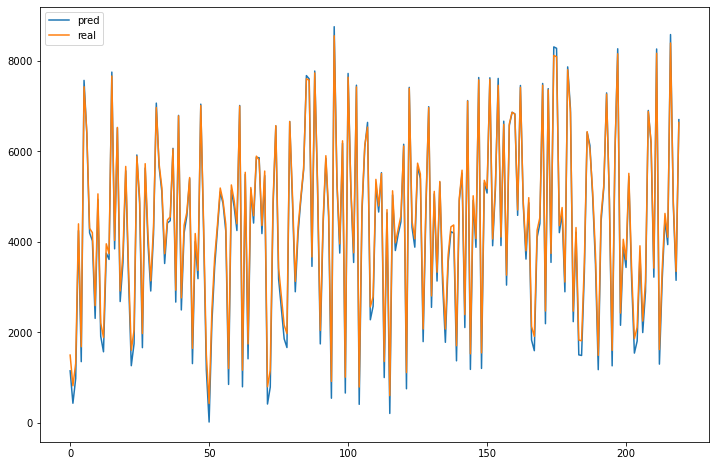

In [139]:
train_validate_report(linreg,x_train_scaled, y_train, x_valid_scaled, y_valid, feature_names=df.columns[:-1])

Ошибка:  278.3318999222579
Коэффициент детерминации 1.0
                    coef
registered  6.017000e+03
casual      3.401000e+03
holiday     2.435772e-12
weathersit  1.845139e-12
season      1.633285e-12
windspeed   1.481947e-12
hum         8.916845e-13
workingday -5.196235e-13
mnth       -7.451399e-13
yr         -1.056957e-12
weekday    -1.422412e-12
temp       -3.398435e-12
atemp      -3.722423e-12


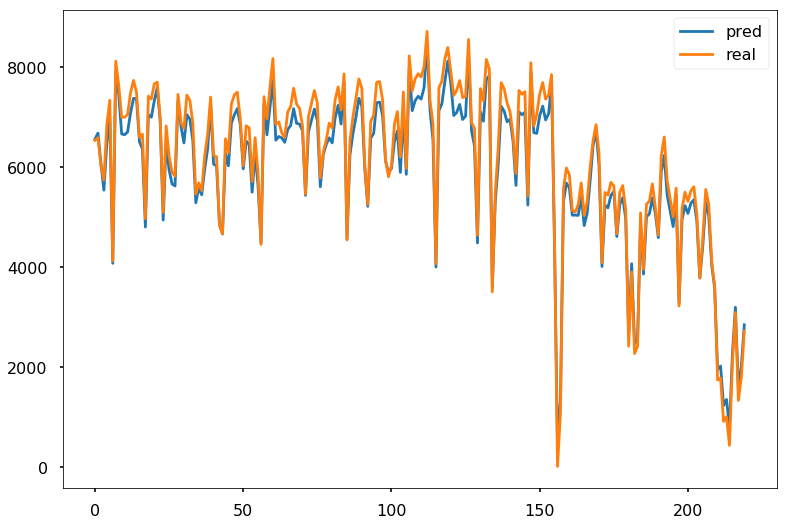

In [54]:
#Линейная регрессия



In [10]:
#Применим метод регуляризации Лассо


In [9]:
#Лассо CV


In [8]:
#Альфы для лассо CV


In [7]:
#Метод ridge


In [6]:
#Метод ridge cv


## Придумать свой способ обучения модели (удаление незначащих данных, коррелирующих значений и тд)
### Сделать визуализацию и соответствующие выводы

In [ ]:
#Сделаем новую таблицу без...



In [3]:
#построим корреляционную матрицу и попробуем избавиться от незначащих переменных


In [145]:
#Теперь попробуем избавиться от переменных, которые могут быть взаимосвязаны между собой и тем самым
#портить качество модели
